In [3]:
import os

import numpy as np
import tensorflow as tf

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.utils import plot_model

In [5]:
os.chdir('..')

In [4]:
from src.resnet_arch import resnet_block

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Setting seed for reproducibility
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [8]:
X_train_combined = np.load('./data/X_train_combined.npy')
y_train_combined = np.load('./data/y_train_combined.npy')

In [9]:
X_val = np.load('./data/X_val.npy')
y_val = np.load('./data/y_val.npy')

X_train_combined.shape, y_train_combined.shape, X_val.shape, y_val.shape

((130050, 32, 32, 32, 1),
 (130050, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1))

In [10]:
sample_size_train = int(0.9 * X_train_combined.shape[0])
sample_size_val = int(0.9 * X_val.shape[0])

indices_train = np.random.choice(X_train_combined.shape[0], sample_size_train, replace=False)
indices_val = np.random.choice(X_val.shape[0], sample_size_val, replace=False)

X_train_sample = X_train_combined[indices_train]
y_train_sample = y_train_combined[indices_train]
X_val_sample = X_val[indices_val]
y_val_sample = y_val[indices_val]

X_train_sample.shape, y_train_sample.shape, X_val_sample.shape, y_val_sample.shape

((117045, 32, 32, 32, 1),
 (117045, 32, 32, 32, 1),
 (17212, 32, 32, 32, 1),
 (17212, 32, 32, 32, 1))

In [11]:
# Parameters
Ngrid = 32  # grid size

In [12]:
res_model = resnet_block(Ngrid, filters=64)

2024-03-05 22:57:16.104175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 22:57:16.652208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [13]:
# Compile the model
res_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)

checkpoint = ModelCheckpoint('models/resnet/050324_90p_samp_augment.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [16]:
history = res_model.fit(x=X_train_sample, 
                         y=y_train_sample, 
                         validation_data=(X_val_sample, y_val_sample),
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-03-05 22:58:00.910536: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-03-05 22:58:13.215676: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3658/3658 [==============================] - ETA: 0s - loss: 0.5333 - mae: 0.4922
Epoch 1: val_loss improved from inf to 0.39960, saving model to models/resnet/050324_90p_samp_augment.hdf5
3658/3658 [==============================] - 277s 70ms/step - loss: 0.5333 - mae: 0.4922 - val_loss: 0.3996 - val_mae: 0.4234 - lr: 0.0010
Epoch 2/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4991 - mae: 0.4716
Epoch 2: val_loss improved from 0.39960 to 0.39569, saving model to models/resnet/050324_90p_samp_augment.hdf5
3658/3658 [==============================] - 252s 69ms/step - loss: 0.4991 - mae: 0.4716 - val_loss: 0.3957 - val_mae: 0.4181 - lr: 0.0010
Epoch 3/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4953 - mae: 0.4691
Epoch 3: val_loss improved from 0.39569 to 0.39120, saving model to models/resnet/050324_90p_samp_augment.hdf5
3658/3658 [==============================] - 252s 69ms/step - loss: 0.4953 - mae: 0.4691 - val_loss: 0.3912 - val_mae: 0.4163

Epoch 28/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4866 - mae: 0.4637
Epoch 28: val_loss did not improve from 0.38294
3658/3658 [==============================] - 251s 69ms/step - loss: 0.4867 - mae: 0.4637 - val_loss: 0.3863 - val_mae: 0.4223 - lr: 0.0010
Epoch 29/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4866 - mae: 0.4637
Epoch 29: val_loss improved from 0.38294 to 0.38233, saving model to models/resnet/050324_90p_samp_augment.hdf5
3658/3658 [==============================] - 252s 69ms/step - loss: 0.4866 - mae: 0.4636 - val_loss: 0.3823 - val_mae: 0.4146 - lr: 0.0010
Epoch 30/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4866 - mae: 0.4636
Epoch 30: val_loss did not improve from 0.38233
3658/3658 [==============================] - 251s 69ms/step - loss: 0.4865 - mae: 0.4636 - val_loss: 0.3824 - val_mae: 0.4131 - lr: 0.0010
Epoch 31/50
3657/3658 [============================>.] - ETA: 0s - loss: 0.4864 - mae: 0.4636

### Model saved

In [9]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 32,   4160        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                           

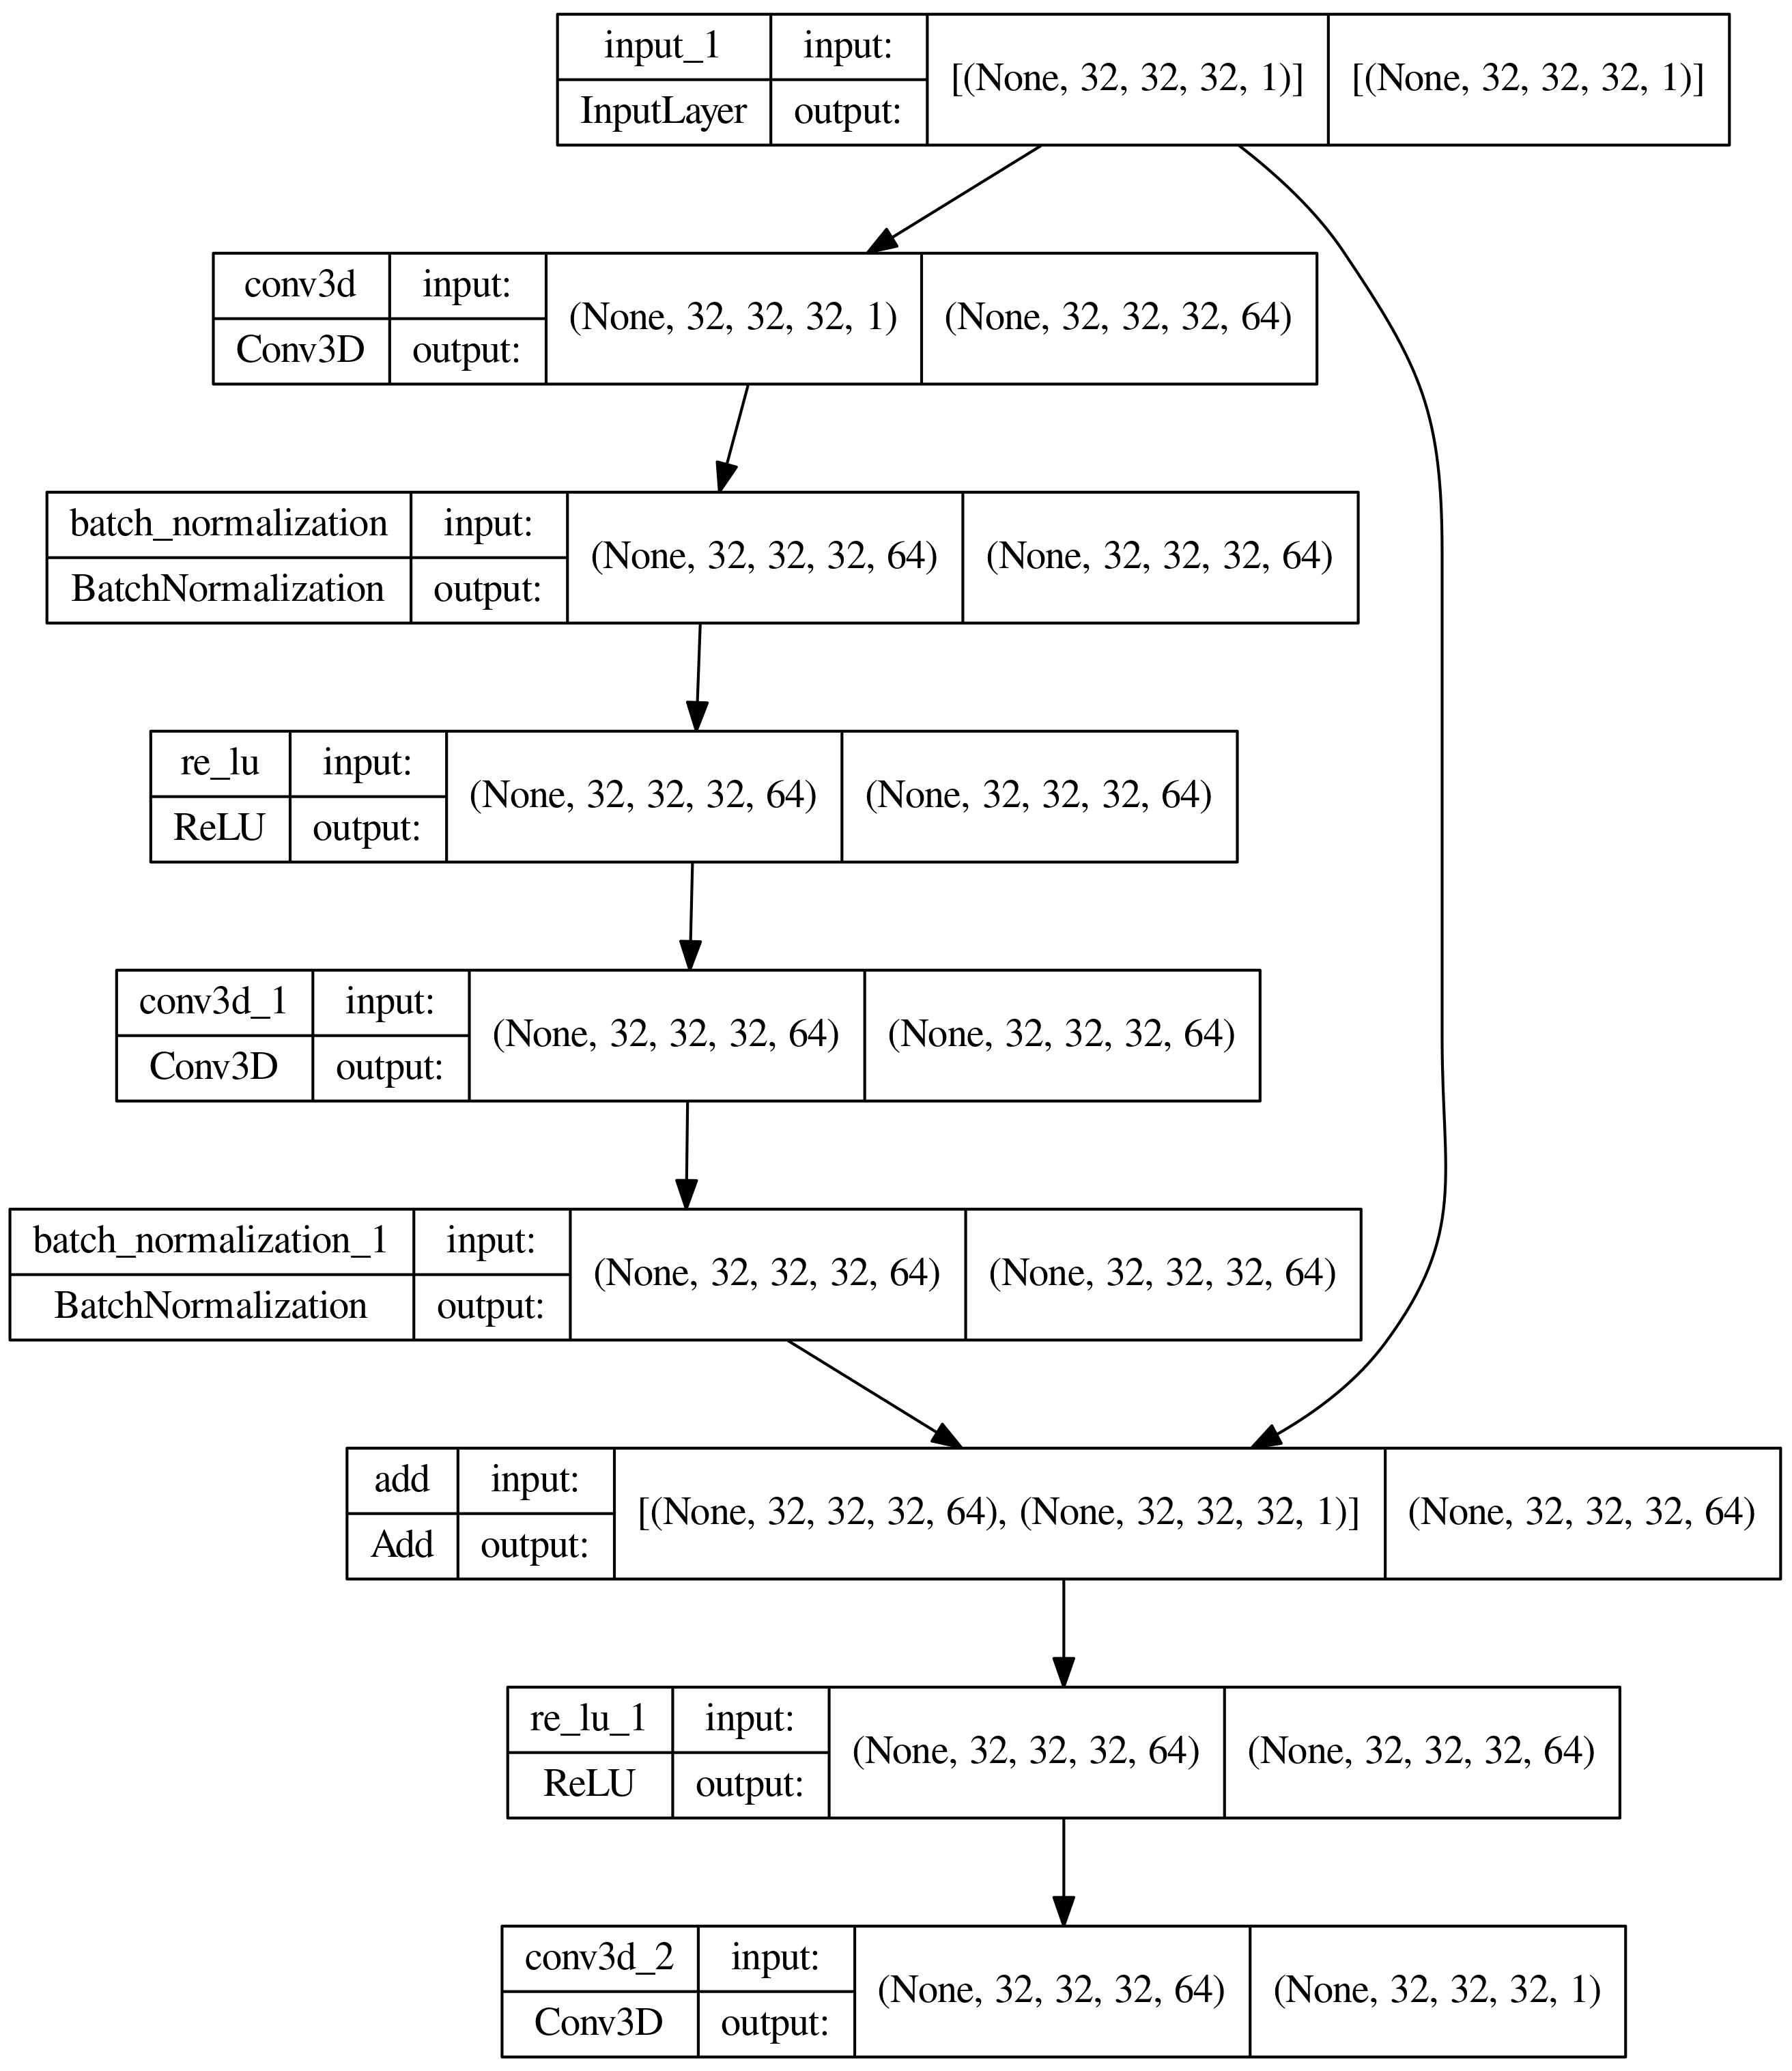

In [11]:
plot_model(res_model, 
           to_file='models/resnet/resnet_model.png',
           show_shapes=True, 
           show_layer_names=True, 
           dpi=300)

# Script Complete